Momentum Classifier

- inputs
    - labels: trend-scanning labeling (up vs. down & no trend)
    - features: market-data selected features

- models: SVM, Random Forest, Gradient Boosting, LSTM

- outputs
    - momentum signals

In [1]:
# lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
plt.style.use('tableau-colorblind10')

# different models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score

from features import tautil
from labeling import labeling
from mlutil.pkfold import PKFold

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

# get X,y

In [3]:
market_df = pd.read_csv('C:data/market_samsung.csv')
market_df = market_df.rename(columns={market_df.columns[0]:'Date'})
market_df.index = pd.to_datetime(market_df.Date)
market_df.drop(columns='Date',inplace=True)
market_df.dropna(inplace=True)

feature_df = pd.read_csv('C:data/features_samsung.csv')
feature_df = feature_df.rename(columns={feature_df.columns[0]:'Date'})
feature_df.index = pd.to_datetime(feature_df.Date)
feature_df.drop(columns='Date',inplace=True)
feature_df.dropna(inplace=True)

In [4]:
selected_features = pd.read_csv('C:data/selected_features.csv').columns[1:]

In [5]:
feature = feature_df.dropna()
feature = feature[selected_features]

sc = StandardScaler()
X_sc = sc.fit_transform(feature)
X_sc = pd.DataFrame(X_sc, index=feature.index, columns=feature.columns)

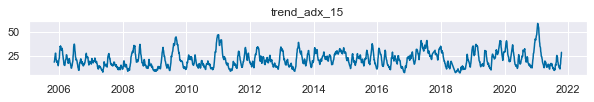

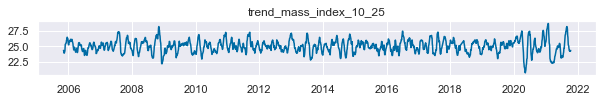

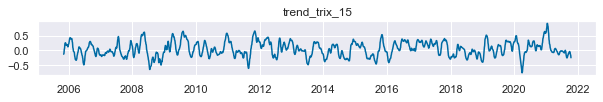

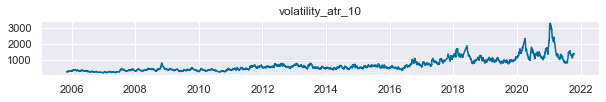

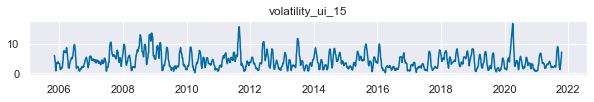

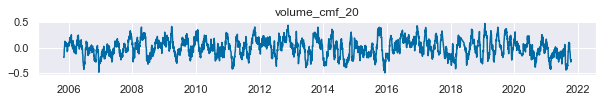

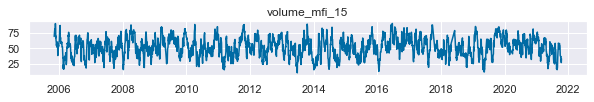

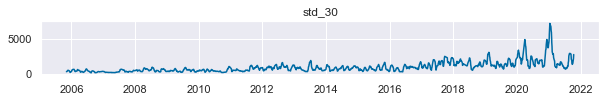

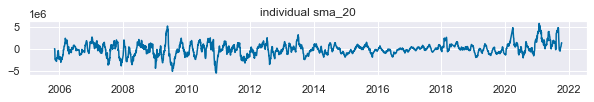

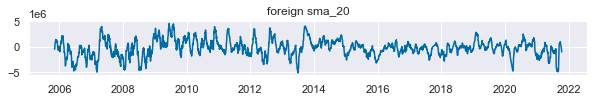

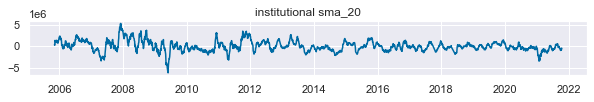

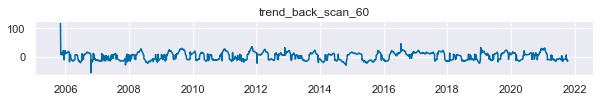

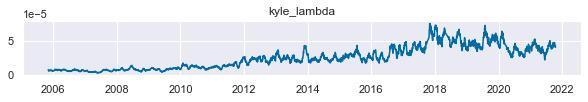

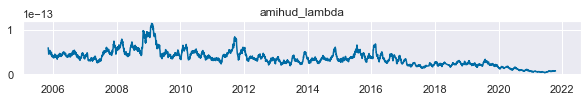

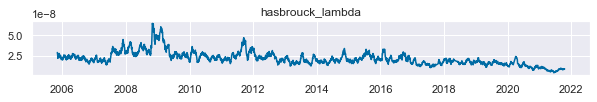

In [6]:
for i in feature.columns:
    plt.figure(figsize=(10,1))
    plt.title(i)
    plt.plot(feature[i])

In [7]:
#labeling
trend_scanning_window = 60
trend_scanning_q = 3
ts_out = labeling.trend_scanning_label(market_df['2010':].close, window = trend_scanning_window, q = trend_scanning_q)
mom_label = ts_out[0]

In [8]:
y = np.sign(mom_label-1)+1 # up-trend vs. others(down-trend and no-trend)

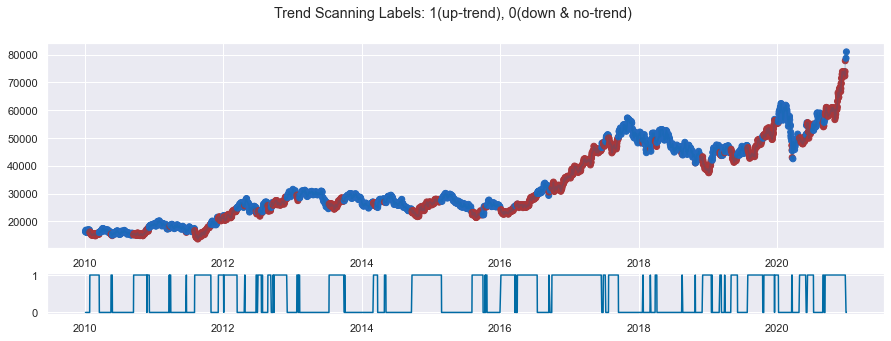

In [9]:
y_ = y[:'2020']
close = market_df.close.loc[y_.index]
f, (a0, a1) = plt.subplots(2, gridspec_kw={'height_ratios': [5, 1]}, figsize=(15,5))
f.suptitle("Trend Scanning Labels: 1(up-trend), 0(down & no-trend)")
a0.plot(close,alpha=0.2)
a0.scatter(close.index,close,c=y_, cmap='vlag')
a1.plot(y_.fillna(0.5))
f.show()

In [10]:
raw_X = X_sc.copy()

tmp = raw_X.join(y).dropna()
X=tmp.iloc[:,:-1]
y=tmp.iloc[:,-1]

# Models & Models with Hyperparameter tuning

In [11]:
# Cross Validation (purged k-fold)
n_cv=4
t1= ts_out[1].loc[X.index]
cv = PKFold(n_cv,t1,0.01)

In [12]:
# Choose model (SVM-rbf)
C = [0.1, 1, 10]
param_grid_rbf = dict(C=C)
svc_rbf = SVC(kernel='rbf', probability=True)
gs_svc_rbf = GridSearchCV(estimator=svc_rbf, param_grid= param_grid_rbf, cv=cv)
gs_svc_rbf.fit(X,y)
svc_best = gs_svc_rbf.best_estimator_
svc_best

SVC(C=0.1, probability=True)

In [13]:
n_estimators = [500,1000]
max_depth = [3,5]
param_grid_rfc = dict(n_estimators=n_estimators, max_depth=max_depth)
rfc = RandomForestClassifier(class_weight='balanced')
gs_rfc = GridSearchCV(estimator=rfc, param_grid= param_grid_rfc, cv=cv)
gs_rfc.fit(X,y)
rfc_best = gs_rfc.best_estimator_
rfc_best

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=1000)

In [14]:
n_estimators_ab = [200,500]
learning_rate = [0.01,0.1]
param_grid_abc = dict(n_estimators=n_estimators_ab, learning_rate=learning_rate)

abc=AdaBoostClassifier()
gs_abc = GridSearchCV(estimator=abc, param_grid= param_grid_abc, cv=cv)
gs_abc.fit(X,y)
ada_best = gs_abc.best_estimator_
ada_best

AdaBoostClassifier(learning_rate=0.01, n_estimators=200)

In [15]:
n_estimators_gb = [200,500]
learning_rate = [0.01,0.1]
param_grid_gbc = dict(n_estimators=n_estimators_gb, learning_rate=learning_rate)
gbc=GradientBoostingClassifier()
gs_gbc = GridSearchCV(estimator=gbc, param_grid= param_grid_gbc, cv=cv)
gs_gbc.fit(X,y)
gbc_best = gs_gbc.best_estimator_
gbc_best

GradientBoostingClassifier(n_estimators=200)

In [16]:
clf_list = [svc_best, rfc_best, ada_best, gbc_best]
estimators=['SVM_best','RF_best','AdaBoost_best','GradientBoost_best']
scores_list = []
y_preds_list = []
y_probs_list = []

# for ML model prediction
for clf in clf_list:
    y_preds_ = []
    y_probs_ = []

    for train, test in cv.split(X, y):
        clf.fit(X.iloc[train], y.iloc[train])
        y_true = y.iloc[test]
        y_pred = clf.predict(X.iloc[test])
        y_probs = clf.predict_proba(X.iloc[test])
        y_probs = y_probs[:, 1]
        y_pred_series = pd.Series(y_pred,index=y[test].index)
        y_probs_series = pd.Series(y_probs,index=y[test].index)
        y_preds_.append(y_pred_series)
        y_probs_.append(y_probs_series)
    
    
    y_preds__ = pd.concat([i for i in y_preds_])
    y_probs__ = pd.concat([i for i in y_probs_])
    y_true__ = y.loc[y_preds__.index]
    accs = accuracy_score(y_true__, y_preds__)
    f1=f1_score(y_true__, y_preds__)
    roc=roc_auc_score(y_true__, y_probs__)
    prec=precision_score(y_true__, y_preds__)
    score = [accs, f1, roc, prec]
    scores_list.append(score)
    y_preds_list.append(y_preds__)
    y_probs_list.append(y_probs__)

In [17]:
results = pd.DataFrame(scores_list, columns=['accuracy','f1 score','roc auc score','precision score'],index=estimators)
result_show = results.sort_values('accuracy', ascending=False)
result_show

,accuracy,f1 score,roc auc score,precision score
AdaBoost_best,0.563135,0.123726,0.448611,0.412621
SVM_best,0.510160,0.299793,0.476269,0.380263
GradientBoost_best,0.493832,0.468166,0.489565,0.421993
RF_best,0.488389,0.503871,0.498126,0.427718


In [18]:
y_probs_df = pd.concat(y_probs_list, axis=1).dropna()
y_probs_df.columns = estimators

y_probs_df['mean_'] = y_probs_df.mean(axis=1)

momentum = pd.Series(y_probs_df.mean_,index=y_probs_df.index)

# Select the model

array([0.15405224, 0.22668779, 0.29932334, 0.37195889, 0.44459443,
       0.51722998, 0.58986553, 0.66250108, 0.73513662, 0.80777217,
       0.88040772])

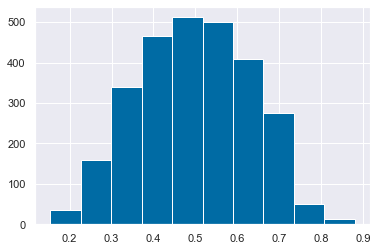

In [19]:
plt.hist(momentum)[1]

In [20]:
momentum = momentum.loc['2010':'2020']

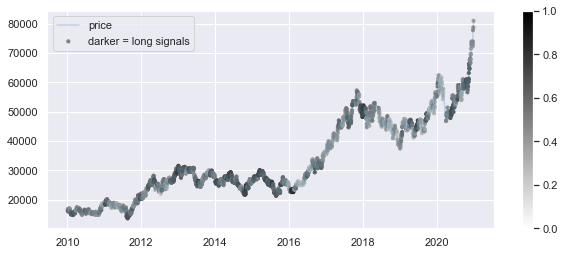

In [21]:
close = market_df.close.loc[momentum.index]
plt.figure(figsize=(10,4))
plt.plot(close, alpha=0.2)
#plt.title('Momentum signals')
plt.scatter(momentum.index, close, c=momentum, s=10,cmap='gray_r',vmin=0,vmax=1)
plt.colorbar()
plt.legend(['price','darker = long signals'])
plt.show()

In [22]:
momentum.rename('signals').to_csv('C:data/momentum_signals.csv')